# lecture

최규빈  
2025-06-04

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/09wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-xRfokRN58uC0Mr4NGrJiWX&si=PhVcbmFUN0x3TLfN >}}

# 2. Imports

In [2]:
import gymnasium as gym
#---#
import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython

# 3. 지난시간 코드 복습

`-` 클래스선언

-   수정사항: (1) deque의 maxlen을 500000 으로 조정 (2) print하는 코드를
    주석처리

In [3]:
class GridWorld:
    def __init__(self):
        self.a2d = {
            0: np.array([0,1]), # →
            1: np.array([0,-1]), # ←  
            2: np.array([1,0]),  # ↓
            3: np.array([-1,0])  # ↑
        }
        self.state_space = gym.spaces.MultiDiscrete([4,4])
        self.state = np.array([0,0])
        self.reward = None
        self.terminated = False
    def step(self,action):
        self.state = self.state + self.a2d[action]
        s1,s2 = self.state
        if (s1==3) and (s2==3):
            self.reward = 100 
            self.terminated = True
        elif self.state in self.state_space:
            self.reward = -1 
            self.terminated = False
        else:
            self.reward = -10
            self.terminated = True
        # print(
        #     f"action = {action}\t"
        #     f"state = {self.state - self.a2d[action]} -> {self.state}\t"
        #     f"reward = {self.reward}\t"
        #     f"termiated = {self.terminated}"
        # )            
        return self.state, self.reward, self.terminated
    def reset(self):
        self.state = np.array([0,0])
        self.terminated = False
        return self.state
class RandomAgent:
    def __init__(self):
        self.state = np.array([0,0]) 
        self.action = None 
        self.reward = None 
        self.next_state = None
        self.terminated = None
        #---#
        self.states = collections.deque(maxlen=500000)
        self.actions = collections.deque(maxlen=500000)
        self.rewards = collections.deque(maxlen=500000)
        self.next_states = collections.deque(maxlen=500000)
        self.terminations = collections.deque(maxlen=500000)
        #---#
        self.action_space = gym.spaces.Discrete(4)
        self.n_experience = 0
    def act(self):
        self.action = self.action_space.sample()
    def save_experience(self):
        self.states.append(self.state)
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated)
        self.n_experience = self.n_experience + 1
    def learn(self):
        pass

`-` 메인코드

-   수정사항: 가독성을 위해 에피소드가 진행되는 for문의 구조를 수정함
    (특히 step4)

``` python
player = RandomAgent()
env = GridWorld()
scores = [] 
score = 0 
#
for e in range(1,100):
    #---에피소드시작---#
    while True:
        # step1 -- 액션선택
        player.act()
        # step2 -- 환경반응 
        player.next_state, player.reward, player.terminated = env.step(player.action)
        # step3 -- 경험기록 & 학습 
        player.save_experience()
        player.learn()
        # step4 --종료 조건 체크 & 후속 처리
        if env.terminated:
            score = score + player.reward
            scores.append(score)
            score = 0 
            player.state = env.reset() 
            print(f"---에피소드{e}종료---")
            break
        else: 
            score = score + player.reward
            scores.append(score)            
            player.state = player.next_state
    #---에피소드끝---#
    if scores[-1] > 0:
        break
```

> **Note**
>
> 마음에 들지 않지만 꼭 외워야 하는것
>
> 1.  `env.step`은 항상 next_state, reward, terminated, truncated, info
>     를 리턴한다. – 짐나지엄 라이브러리 규격때문
> 2.  `env.reset`은 환경을 초기화할 뿐만 아니라, state, info를 반환하는
>     기능도 있다. – 짐나지엄 라이브러리 규격때문
> 3.  `player`는 항상 `state`와 `next_state`를 구분해서 저장한다.
>     (다른변수들은 그렇지 않음) 이는 강화학습이
>     MDP(마코프체인+행동+보상)구조를 따르게 때문에 생기는 고유한
>     특징이다. – 이론적이 이유

`-` 환경과 에이전트의 상호작용 이해를 위한 다이어그램:

-   <https://claude.ai/public/artifacts/7fad72b5-0946-47bd-a6cd-b33b21856590>

# 4. GridWorld 환경의 이해

## A. 데이터 축적

`-` 랜덤에이전트를 이용해 무작위로 100,000 에피소드를 진행해보자.

In [4]:
player = RandomAgent()
env = GridWorld()
scores = [] 
score = 0 
#
for e in range(1,100000):
    #---에피소드시작---#
    while True:
        # step1 -- 액션선택
        player.act()
        # step2 -- 환경반응 
        player.next_state, player.reward, player.terminated = env.step(player.action)
        # step3 -- 경험기록 & 학습 
        player.save_experience()
        player.learn()
        # step4 --종료 조건 체크 & 후속 처리
        if env.terminated:
            score = score + player.reward
            scores.append(score)
            score = 0 
            player.state = env.reset() 
            break
        else: 
            score = score + player.reward
            scores.append(score)            
            player.state = player.next_state

In [5]:
player.n_experience

## B. 첫번째 `q_table`

`-` 밴딧게임에서는 $Q(a)$ 를 정의했었음.

-   $Q(0) = 1$
-   $Q(1) = 10$

`-` 여기에서는 $Q(s_1,s_2,a)$를 정의해야함!

> **Note**
>
> 직관적으로 아래의 그림이 떠오름
> 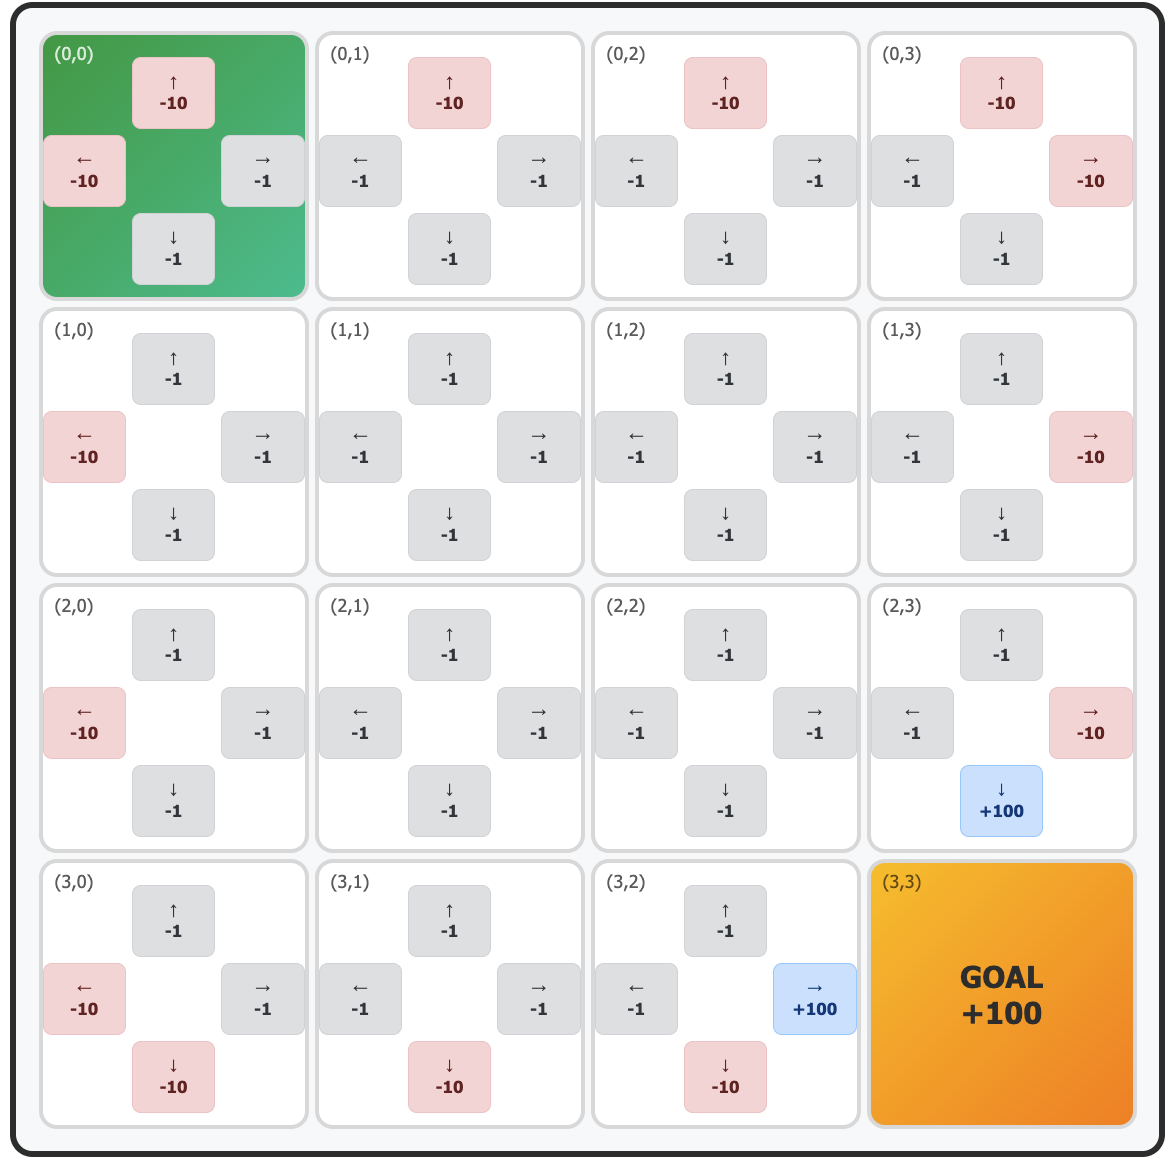
>
> 그림에 대응하는 $Q(s_1,s_2,a)$의 값은 아래와 같음
>
> ### $a=0$
>
> $a=0 \Leftrightarrow \text{\tt action=right}$
>
> $$ \begin{bmatrix}
> Q(0,0,0) & Q(0,1,0) & Q(0,2,0) & Q(0,3,0) \\ 
> Q(1,0,0) & Q(1,1,0) & Q(1,2,0) & Q(1,3,0) \\ 
> Q(2,0,0) & Q(2,1,0) & Q(2,2,0) & Q(2,3,0) \\ 
> Q(3,0,0) & Q(3,1,0) &Q(3,2,0) & Q(3,3,0) \\ 
> \end{bmatrix} =  \begin{bmatrix}
> -1 & -1 & -1 & -10 \\ 
> -1 & -1 & -1 & -10 \\ 
> -1 & -1 & -1 & -10 \\ 
> -1 & -1 & 100 &  \text{-} \\ 
> \end{bmatrix}
> $$
>
> ### $a=1$
>
> $a=1 \Leftrightarrow \text{\tt action=left}$
>
> $$ \begin{bmatrix}
> Q(0,0,1) & Q(0,1,1) & Q(0,2,1) & Q(0,3,1) \\ 
> Q(1,0,1) & Q(1,1,1) & Q(1,2,1) & Q(1,3,1) \\ 
> Q(2,0,1) & Q(2,1,1) & Q(2,2,1) & Q(2,3,1) \\ 
> Q(3,0,1) & Q(3,1,1) &Q(3,2,1) & Q(3,3,1) \\ 
> \end{bmatrix} = \begin{bmatrix}
> -10 & -1 & -1 & -1 \\ 
> -10& -1 & -1 & -1 \\ 
> -10 & -1 & -1 & -1 \\ 
> -10 & -1 & -1 &  \text{-} \\ 
> \end{bmatrix}
> $$
>
> ### $a=2$
>
> $a=2 \Leftrightarrow \text{\tt action=down}$
>
> $$  \begin{bmatrix}
> Q(0,0,2) & Q(0,1,2) & Q(0,2,2) & Q(0,3,2) \\ 
> Q(1,0,2) & Q(1,1,2) & Q(1,2,2) & Q(1,3,2) \\ 
> Q(2,0,2) & Q(2,1,2) & Q(2,2,2) & Q(2,3,2) \\ 
> Q(3,0,2) & Q(3,1,2) &Q(3,2,2) & Q(3,3,2) \\ 
> \end{bmatrix} = \begin{bmatrix}
> -1 & -1 & -1 & -1 \\ 
> -1& -1 & -1 & -1 \\ 
> -1 & -1 & -1 & 100\\ 
> -10 & -10 & -10 &  \text{-} \\ 
> \end{bmatrix}
> $$
>
> ### $a=3$
>
> $a=3 \Leftrightarrow \text{\tt action=up}$
>
> $$  \begin{bmatrix}
> Q(0,0,3) & Q(0,1,3) & Q(0,2,3) & Q(0,3,3) \\ 
> Q(1,0,3) & Q(1,1,3) & Q(1,2,3) & Q(1,3,3) \\ 
> Q(2,0,3) & Q(2,1,3) & Q(2,2,3) & Q(2,3,3) \\ 
> Q(3,0,3) & Q(3,1,3) &Q(3,2,3) & Q(3,3,3) \\ 
> \end{bmatrix} =\begin{bmatrix}
> -10 & -10 & -10 & -10\\ 
> -1& -1 & -1 & -1 \\ 
> -1 & -1 & -1 & -1 \\ 
> -1 & -1 & -1 &  \text{-} \\ 
> \end{bmatrix}
> $$

`-` 데이터를 바탕으로 $Q(s_1,s_2,a)$를 구해보자. (은근어려움)

In [35]:
q_table = np.zeros([4,4,4])
count = np.zeros([4,4,4])

In [36]:
for (s1,s2), a, r  in zip(player.states, player.actions, player.rewards):
    q_table[s1,s2,a] = q_table[s1,s2,a] + r 
    count[s1,s2,a] = count[s1,s2,a] + 1 

In [37]:
count[count == 0] = 0.000001
q_table = q_table / count 

In [38]:
q_table[...,0]

`-` count를 사용하지 않는 방법은 없을까? – 테크닉

In [40]:
q_table = np.zeros([4,4,4])
for (s1,s2), a, r  in zip(player.states, player.actions, player.rewards):
    qhat = q_table[s1,s2,a] 
    q = r 
    diff = q - qhat 
    q_table[s1,s2,a] = q_table[s1,s2,a]  + 0.01 * diff

In [43]:
q_table[...,0].round(2)

## C. 첫번째 `q_table`보다 나은 것?

`-` 첫번째 `q_table`을 알고있다고 가정하자.

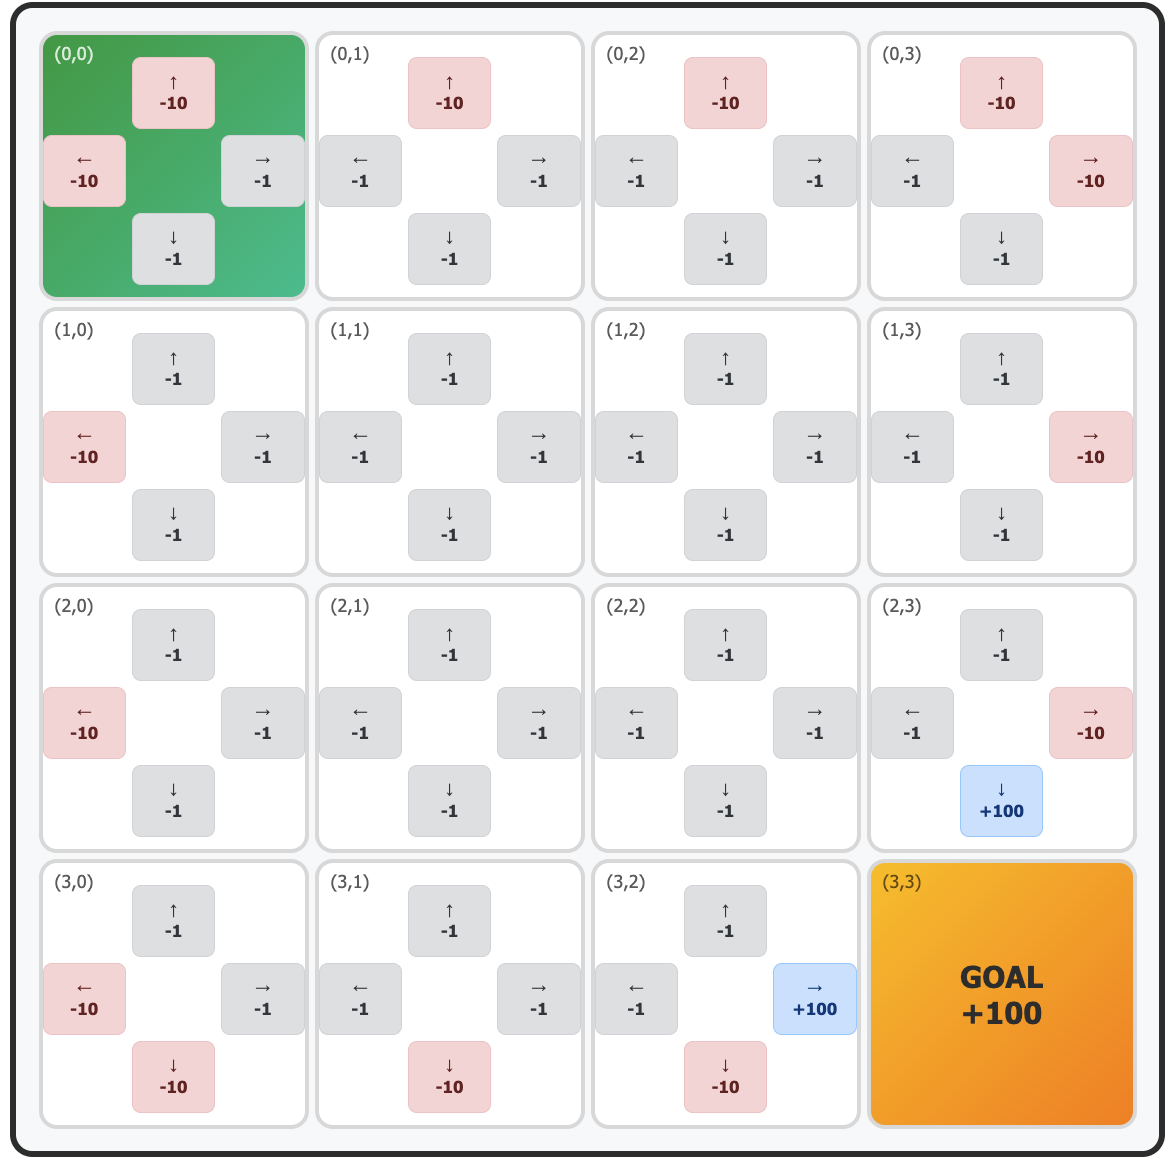

`-` 정책시각화 (합리적인 행동)

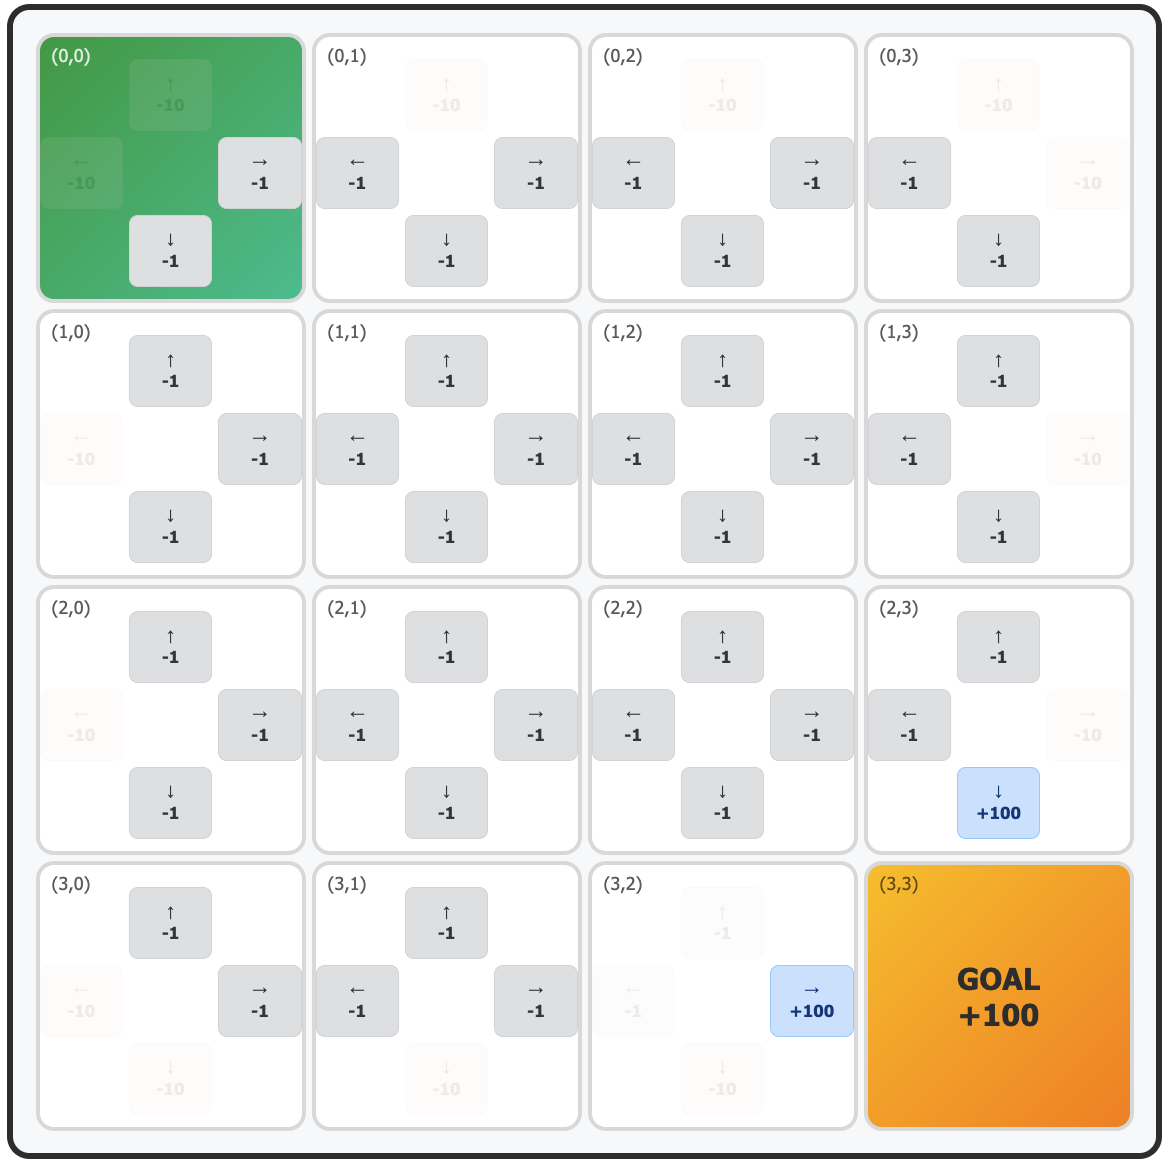

`-` 이게 최선이야?